## Binary classification with Logistic regression 

### import libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pymysql
import getpass

In [2]:
mysqlpassword= getpass.getpass()

········


In [3]:
## First create the connection string
connection_string = 'mysql+pymysql://root:' + mysqlpassword + '@localhost/bank'
engine= create_engine(connection_string)

### connection to sql 

In [4]:
#query as a df
df=pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
DATEDIFF(19981231, convert(a.date,date)) as ageindays, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where l.status in('A','B') and dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, DATEDIFF(19981231, convert(a.date,date)),
 dp.type, round((l.amount-l.payments)/l.amount,2)
''', engine)

In [5]:
#use head to confirm the df works as expected 
df.head()

,loan_id,status,nooftrans,ageindays,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid
0,4959,A,374,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96
1,4961,B,259,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92
2,4962,A,225,886,4.09,4.72,OWNER,30276,620209,5623,5887,0.92
3,4973,A,295,1534,1.12,1.54,OWNER,165960,445613,1874,1913,0.96
4,4986,A,209,970,4.75,5.44,OWNER,102876,420128,18782,18347,0.92


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_id       234 non-null    int64  
 1   status        234 non-null    object 
 2   nooftrans     234 non-null    int64  
 3   ageindays     234 non-null    int64  
 4   95unemp       234 non-null    float64
 5   96unemp       234 non-null    float64
 6   type          234 non-null    object 
 7   loanamount    234 non-null    int64  
 8   birth_number  234 non-null    int64  
 9   crime95       234 non-null    int64  
 10  crime96       234 non-null    int64  
 11  ratiopaid     234 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 22.1+ KB


### EDA - exploratory data analysis - get to know the data 

<AxesSubplot:xlabel='95unemp', ylabel='96unemp'>

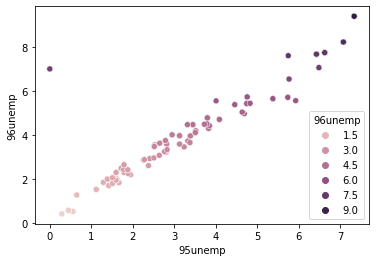

In [7]:
# 
sns.scatterplot(data=df, x="95unemp", y="96unemp", hue="96unemp")

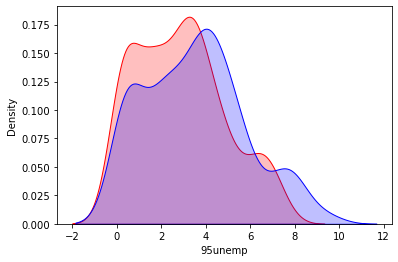

In [8]:
fig = sns.kdeplot(df['95unemp'], shade=True, color="r")
fig = sns.kdeplot(df['96unemp'], shade=True, color="b")
plt.show()

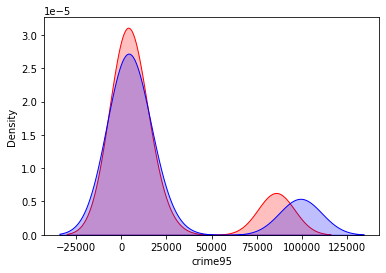

In [9]:
fig = sns.kdeplot(df['crime95'], shade=True, color="r")
fig = sns.kdeplot(df['crime96'], shade=True, color="b")
plt.show()

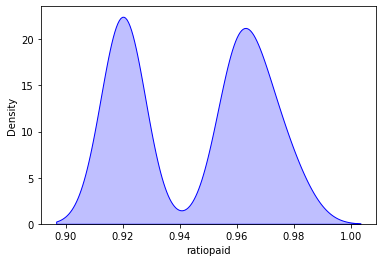

In [10]:
fig = sns.kdeplot(df['ratiopaid'], shade=True, color="b")
plt.show()
## Looks so weird

### histograms or boxplots



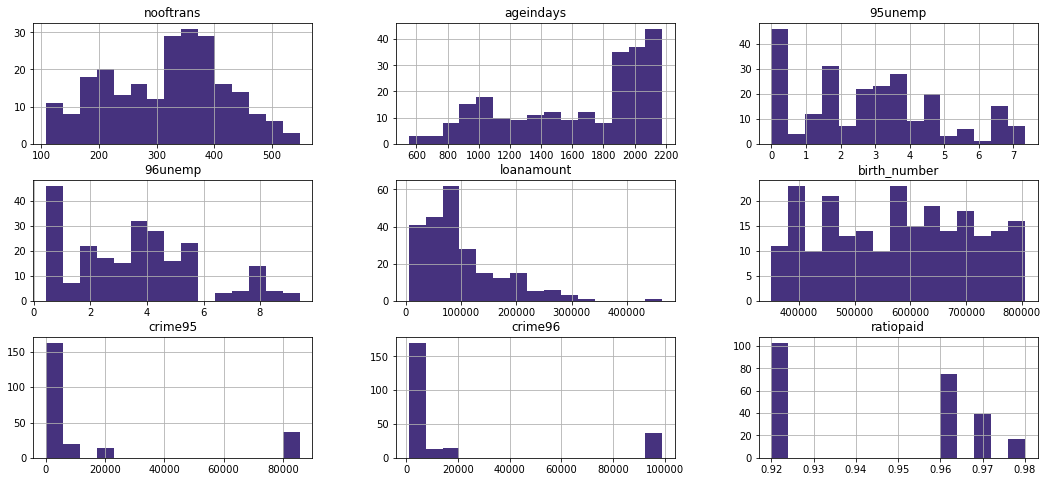

In [45]:
#all histograms 
sns.set_palette("viridis")
df.hist(bins=15, figsize=(18, 8), layout=(3, 3));

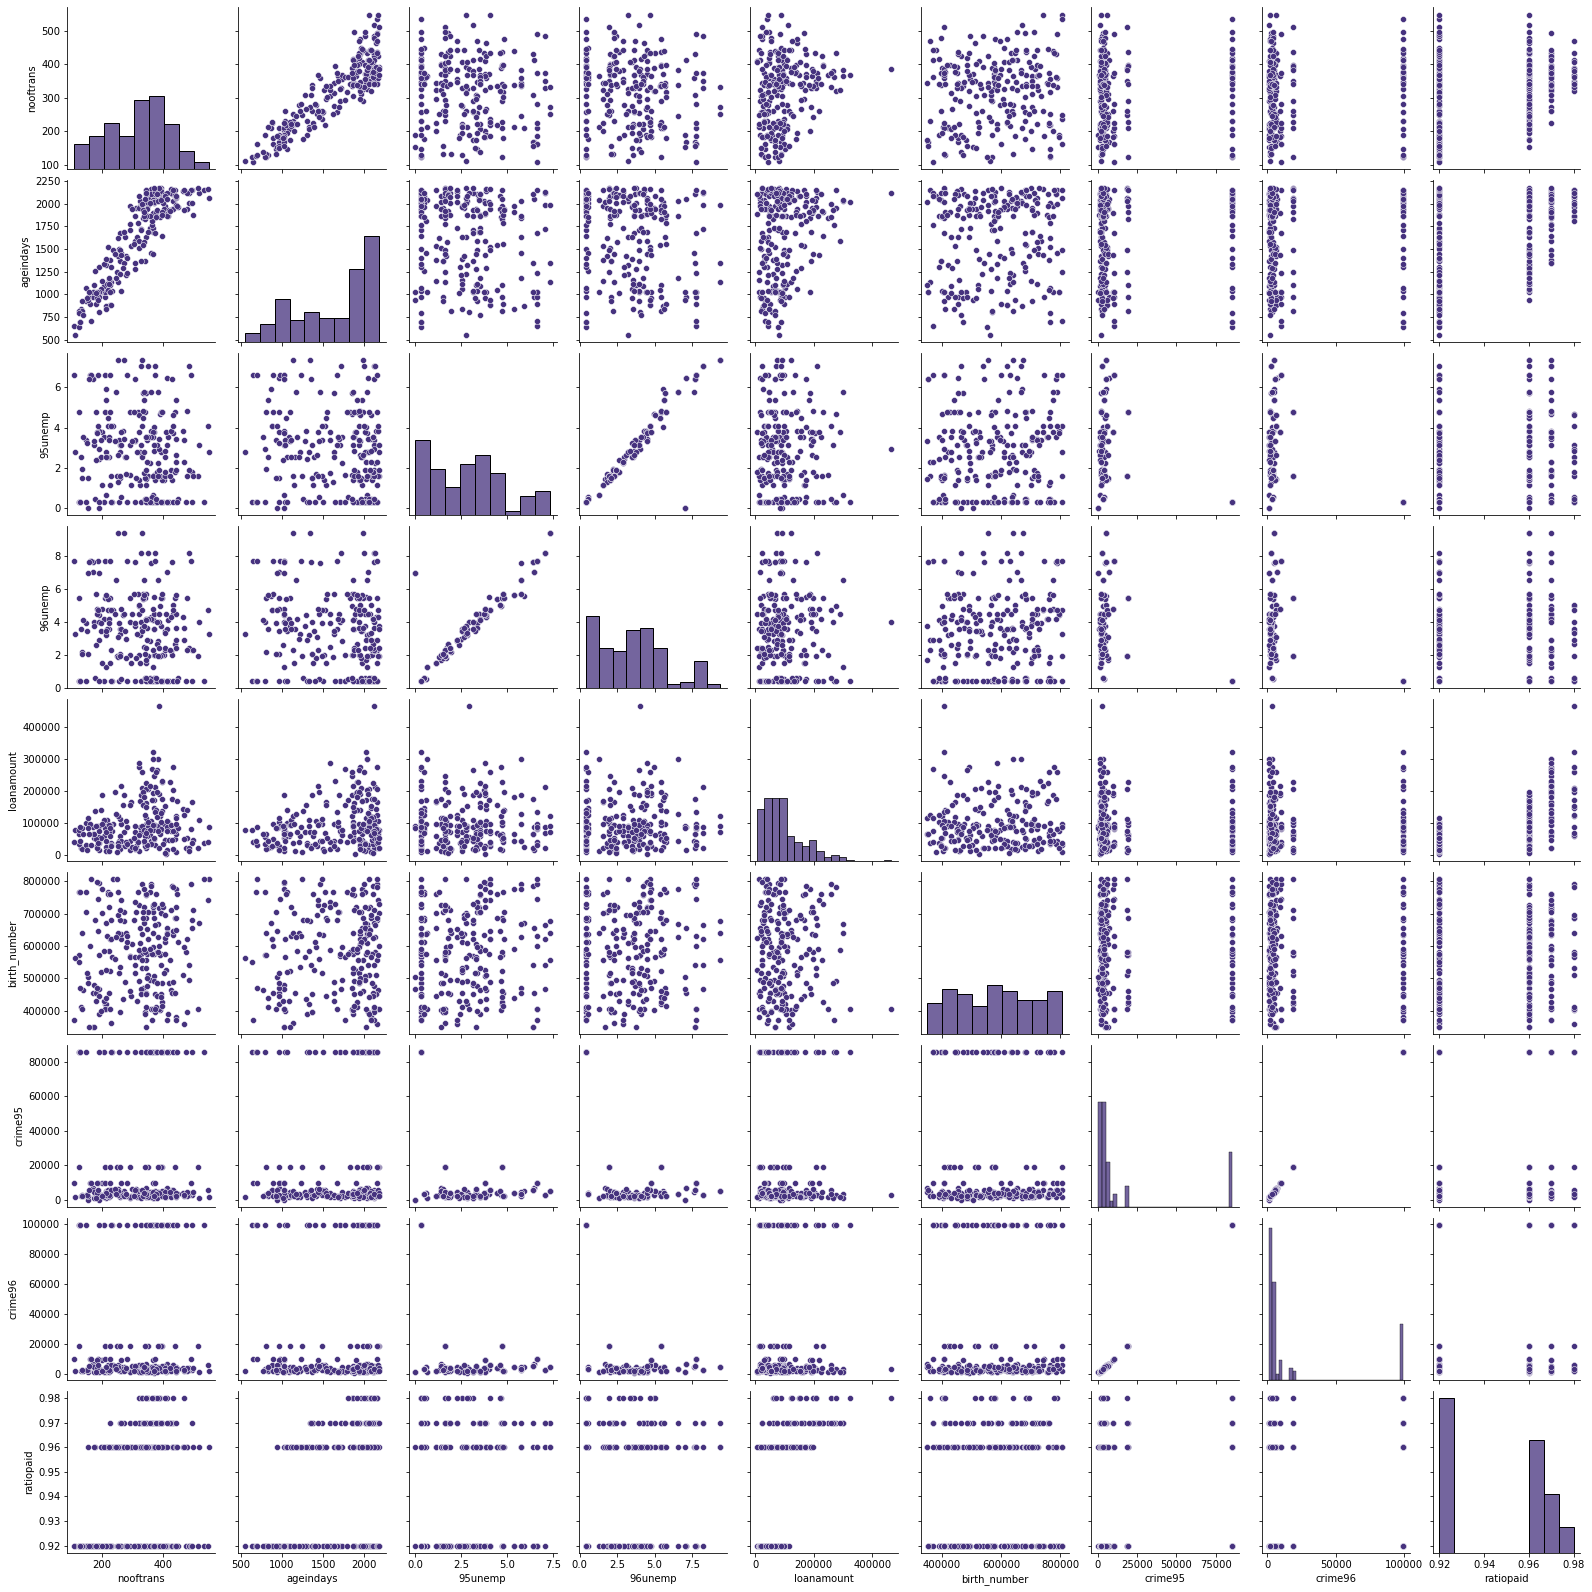

In [43]:
# all scatter plots as a matrix
sns.set_palette("viridis")
sns.pairplot(df)

### Check for multicollinearity 

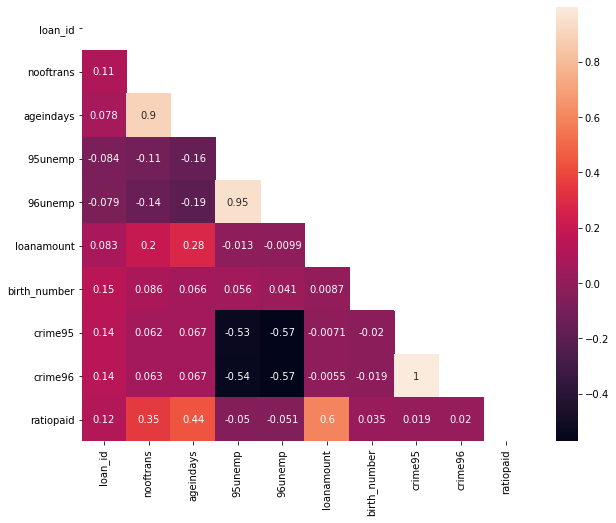

In [11]:
# correlation matrix
corr_matrix=df.corr(method='pearson')
fig,ax=plt.subplots(figsize=(10,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax=sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

In [12]:

df.drop(['loan_id', 'type'], axis=1, inplace=True)


### Clean and wrangling steps 

In [13]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 

#feature engineering - take the columns and make more useful 
# split the data into num and cat --- > diff options cleaning / scaling

### Pre processing 

In [14]:
# label / encode categorical columns 

# scale numerical columns 



In [15]:
cat=df.select_dtypes(include=object)
cat.head()

,status
0,A
1,B
2,A
3,A
4,A


In [22]:
categorical=pd.get_dummies(cat,columns=['status'],drop_first=True)

In [23]:
## numerical scaling
from sklearn.preprocessing import Normalizer

In [24]:
X=df.select_dtypes(include=np.number)

In [25]:
#scaling the numnerical features to normalize 
#optional (with logistic regression) but might help the model 
# once we scale, we convert the array back to a dataframe

scaler=Normalizer().fit(X)
scaled=scaler.transform(X)
scaled_X=pd.DataFrame(scaled)
scaled_X.head()

,0,1,2,3,4,5,6,7,8
0,0.000786,0.004485,6.094747e-07,9.037038e-07,0.170132,0.946165,0.180062,0.208287,0.000002
1,0.000653,0.003439,3.807397e-06,5.219411e-06,0.076340,0.997041,0.005797,0.005936,0.000002
2,0.000362,0.001427,6.586135e-06,7.600625e-06,0.048753,0.998724,0.009055,0.009480,0.000001
3,0.000620,0.003226,2.355295e-06,3.238531e-06,0.349004,0.937098,0.003941,0.004023,0.000002
4,0.000482,0.002238,1.096143e-05,1.255373e-05,0.237404,0.969517,0.043343,0.042339,0.000002


### split off the dependant variable (label)

In [26]:
# y = dependent variable - y status
y = categorical['status_B'] #small y
#independent variables are scaled_X
X= scaled_X #big X

### train test split, get LOG REG model

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# set up the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=40)

## apply model and train model 

In [29]:
classification=LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)

### evaluate accuracy and test 

In [30]:
# estimate area under the curve
probabilities=classification.predict_proba(X_test)
preds=probabilities[:,1]
import sklearn.metrics as metrics
fpr,tpr, threshold =metrics.roc_curve(y_test, preds)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)

0.7817460317460317


#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

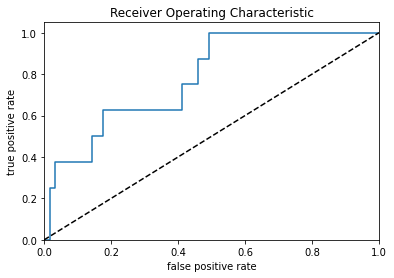

In [31]:
#roc curve plot 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()

### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [32]:
from sklearn.metrics import accuracy_score
predictions =classification.predict(X_test)

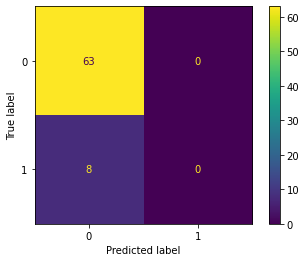

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification,X_test, y_test)
plt.show()

### The model is terrible